### ISSM CA3
Name: Ng Boon Cheong Raymond  
Student ID: A0198543R

In [139]:
import numpy as np
import pandas as pd
import pydot
import IPython
import matplotlib.pyplot as plt
%matplotlib inline

import os
import glob
import time

from keras.layers import Input, Dense, Concatenate
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

### Dataset attributes
Column 1: Timestamp in seconds  
Column 2: Timestamp in microseconds  
Column 3-15: [AccX, AccY, AccZ, GyrX, GyrY, GyrZ, MagX, MagY, MagZ, Q1, Q2, Q3, Q4] of sensor S1 (Left Calf)  
Column 16-28: [AccX, AccY, AccZ, GyrX, GyrY, GyrZ, MagX, MagY, MagZ, Q1, Q2, Q3, Q4] of sensor S2 (Left Thigh)  
Column 29-41: [AccX, AccY, AccZ, GyrX, GyrY, GyrZ, MagX, MagY, MagZ, Q1, Q2, Q3, Q4] of sensor S3 (Right Calf)  
Column 42-54: [AccX, AccY, AccZ, GyrX, GyrY, GyrZ, MagX, MagY, MagZ, Q1, Q2, Q3, Q4] of sensor S4 (Right Thigh)  
Column 55-67: [AccX, AccY, AccZ, GyrX, GyrY, GyrZ, MagX, MagY, MagZ, Q1, Q2, Q3, Q4] of sensor S5 (Back)  
Column 68-80: [AccX, AccY, AccZ, GyrX, GyrY, GyrZ, MagX, MagY, MagZ, Q1, Q2, Q3, Q4] of sensor S6 (Left Lower Arm)  
Column 81-93: [AccX, AccY, AccZ, GyrX, GyrY, GyrZ, MagX, MagY, MagZ, Q1, Q2, Q3, Q4] of sensor S7 (Left Upper Arm)  
Column 94-106: [AccX, AccY, AccZ, GyrX, GyrY, GyrZ, MagX, MagY, MagZ, Q1, Q2, Q3, Q4] of sensor S8 (Right Lower Arm)  
Column 107-119: [AccX, AccY, AccZ, GyrX, GyrY, GyrZ, MagX, MagY, MagZ, Q1, Q2, Q3, Q4] of sensor S9 (Right Upper Arm)  
Column 120: Label (see activity set) [Walking = 1] [Jogging = 2] [Running = 3]

### Run following cells for the following dataset structure:
* df_walk : all 17 subjects + walking + (accel + gyro + quart)  
* df_jog : all 17 subjects + jogging + (accel + gyro + quart)  
* df_run : all 17 subjects + running + (accel + gyro + quart)  
    
Col[0]: Timestamp in seconds  
Col[1]: Timestamp in microseconds  
Col[67-79]: Sensor S6 (without Mag sensor [74 - 76])  
Col[93-105]: Sensor S8 (without Mag sensor [100 - 103])  
Col[119]: Activity Label

In [140]:
data_dir = '..\dataset'
# This method reads all dataset and filter out walking, jogging and running activities
def readcsvDataset(directory):
    files = glob.glob(directory + '\*.csv')
    df_walk = []
    df_jog = []
    df_run = []
    for file in files:
        df_all = pd.read_csv(file, header=None, delim_whitespace=True)
        df_walk.append(df_all[df_all[119] == 1])
        df_jog.append(df_all[df_all[119] == 2])
        df_run.append(df_all[df_all[119] == 3])
    return pd.concat(df_walk, ignore_index=True), pd.concat(df_jog, ignore_index=True), pd.concat(df_run, ignore_index=True)

In [141]:
# This method removes all positional sensors other than left/right lower arm, as well as Magnetic sensors
def removeOtherSensor(df_walk, df_jog, df_run):
    # [2:67] S1 to S5
    # [73:76] Mag sensor for S6
    # [80:93] S7
    # [99:102] Mag sensor for S8
    # [106:119] S9
    idx = np.r_[2:67, 73:76, 80:93, 99,102, 106:119]
    return df_walk.drop(df_walk.columns[idx], axis=1), df_jog.drop(df_jog.columns[idx], axis=1), df_run.drop(df_run.columns[idx], axis=1)

In [142]:
%%time
dfw, dfj, dfr = readcsvDataset(data_dir)

Wall time: 39.1 s


In [143]:
dfwalk, dfjog, dfrun = removeOtherSensor(dfw, dfj, dfr)

In [144]:
standscale = StandardScaler()
dfwalk = standscale.fit_transform(dfwalk)
dfjog = standscale.fit_transform(dfjog)
dfrun = standscale.fit_transform(dfrun)

In [145]:
dfwalk.shape

(45638, 24)

### Run following cells for the following dataset structure:
* df_accel: all 17 subjects + (walk || jog || run) + accel
* df_gyro: all 17 subjects + (walk || jog || run) + gyro
* df_quart: all 17 subjects + (walk || jog || run) + quart

In [146]:
def splitSensor(df):
    # index for time
    idx_time = [0,1]
    # index for activity
    idx_activity = [119]
    # index for accel sensor for S6 and S8
    idx_accel = idx_time + [67, 68, 69, 93, 94, 95] + idx_activity
    # index for gryo sensor for S6 and S8
    idx_gyro = idx_time + [70, 71, 72, 96, 97, 98] + idx_activity
    # index for quart sensor for S6 and S8
    idx_quart = idx_time + [76, 77, 78, 79, 102, 103, 104, 105] + idx_activity
    
    return df[idx_accel], df[idx_gyro], df[idx_quart]

In [147]:
dfaccel, dfgyro, dfquart = splitSensor(dfr)

In [148]:
dfaccel.columns = ['Seconds', 'Microseconds', 'S6_AccX', 'S6_AccY', 'S6_AccZ', 'S8_AccX', 'S8_AccY', 'S8_AccZ', 'Activity']
dfgyro.columns = ['Seconds', 'Microseconds', 'S6_GyrX', 'S6_GyrY', 'S6_GyrZ', 'S8_GyrX', 'S8_GyrY', 'S8_GyrZ', 'Activity']
dfquart.columns = ['Seconds', 'Microseconds', 'S6_Q1', 'S6_Q2', 'S6_Q3', 'S6_Q4', 'S8_Q1', 'S8_Q2', 'S8_Q3', 'S8_Q4', 'Activity']

In [149]:
dfaccel = dfaccel.drop(['Seconds', 'Microseconds', 'Activity'], axis=1)
dfaccel.head()

,S6_AccX,S6_AccY,S6_AccZ,S8_AccX,S8_AccY,S8_AccZ
0,1.4122,-2.41950,14.6970,-3.8459,-5.679600,-4.0406
1,7.0918,-2.31050,18.3930,-12.1090,-2.293900,-6.4204
2,8.6302,-0.81221,15.4420,-22.5160,-1.304600,-4.8783
3,7.5291,1.03300,10.0310,-17.6310,0.057412,-1.6752
4,7.7501,2.09880,6.9139,-14.1530,-0.511720,-1.1493


In [150]:
dfaccel.shape

(40142, 6)

In [151]:
dfgyro = dfgyro.drop(['Seconds', 'Microseconds', 'Activity'], axis=1)
dfgyro.head()

,S6_GyrX,S6_GyrY,S6_GyrZ,S8_GyrX,S8_GyrY,S8_GyrZ
0,-1.63200,-0.55933,0.941290,0.26695,1.5552,0.41222
1,-0.68447,1.45270,0.519170,1.29020,2.7345,1.06410
2,-1.31230,3.91880,0.030051,1.61850,2.4691,0.93687
3,-1.23930,5.87110,0.097996,1.14530,3.5412,0.56630
4,-1.15990,6.80680,0.307600,0.65851,3.8733,-0.14329


In [152]:
dfgyro.shape

(40142, 6)

In [153]:
dfquart = dfquart.drop(['Seconds', 'Microseconds', 'Activity'], axis=1)
dfquart.head()

,S6_Q1,S6_Q2,S6_Q3,S6_Q4,S8_Q1,S8_Q2,S8_Q3,S8_Q4
0,-0.13994,0.17305,0.022179,-0.97467,-0.72138,0.15473,-0.65619,-0.15837
1,-0.13406,0.18831,0.025613,-0.97258,-0.70337,0.14305,-0.67923,-0.15311
2,-0.13217,0.22793,0.033093,-0.96410,-0.68718,0.12908,-0.70003,-0.14520
3,-0.13012,0.28571,0.036735,-0.94873,-0.66257,0.12266,-0.72622,-0.13621
4,-0.12607,0.35101,0.037964,-0.92707,-0.63498,0.12456,-0.75198,-0.12572


In [154]:
dfquart.shape

(40142, 8)

In [155]:
standscale = StandardScaler()
dfaccel = standscale.fit_transform(dfaccel)
dfgyro = standscale.fit_transform(dfgyro)
dfquart = standscale.fit_transform(dfquart)

In [156]:
train_size = np.int(len(dfaccel) * 0.8)
train_accel, test_accel = dfaccel[:train_size], dfaccel[train_size:]
train_gyro, test_gyro = dfgyro[:train_size], dfgyro[train_size:]
train_quart, test_quart = dfquart[:train_size], dfquart[train_size:]

In [157]:
test_accel.shape

(8029, 6)

In [158]:
seed = 42
np.random.seed(seed)

In [188]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
    EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)
]

### Base Model (Accel only)

In [ ]:
# Config
encoder_dimension = 42
EPOCH = 20
BATCH_SIZE = 24

In [184]:
def build_base_model(train_accel):
    # Input dimension
    accel_dim = train_accel.shape[1]
    input_accel = Input(shape=(accel_dim,), name='Input_Accel')
    # Encoder
    encoder = Dense(50, activation='relu', name='Encoder1')(input_accel)
    encoder = Dense(25, activation='relu', name='Encoder2')(encoder)
    # Hidden
    hidden = Dense(5, activation='relu', name='Hidden')(encoder)
    # Decoder
    decoder = Dense(25, activation='relu', name='Decoder1')(hidden)
    decoder = Dense(50, activation='relu', name='Decoder2')(decoder)
    output = Dense(6, activation='relu', name='Output')(decoder)
    model = Model(inputs=input_accel, output=output)
    return model

In [185]:
bmodel = build_base_model(train_accel)
bmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Accel (InputLayer)     (None, 6)                 0         
_________________________________________________________________
Encoder1 (Dense)             (None, 50)                350       
_________________________________________________________________
Encoder2 (Dense)             (None, 25)                1275      
_________________________________________________________________
Hidden (Dense)               (None, 5)                 130       
_________________________________________________________________
Decoder1 (Dense)             (None, 25)                150       
_________________________________________________________________
Decoder2 (Dense)             (None, 50)                1300      
_________________________________________________________________
Output (Dense)               (None, 6)                 306       
Total para

D:\Anaconda3\envs\issmca3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("In..., outputs=Tensor("Ou...)`
  


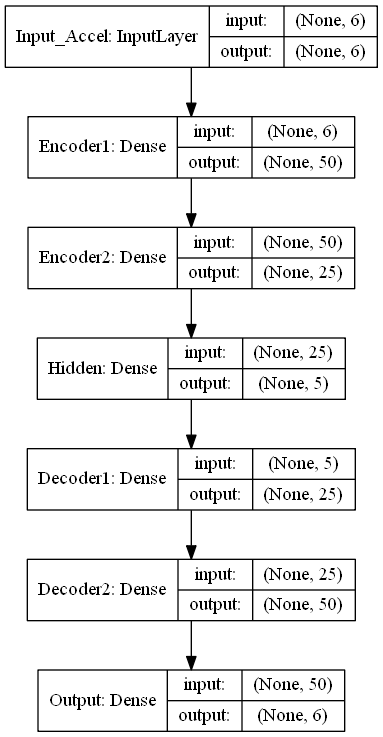

In [187]:
plot_model(bmodel, 
           to_file='modelb.png', 
           show_shapes=True,
           show_layer_names=True)
IPython.display.Image('modelb.png')

In [192]:
bmodel.compile(optimizer='adam', metrics=['accuracy'], loss=['mean_squared_logarithmic_error'])

In [193]:
%%time
bhistory = bmodel.fit(train_accel, train_accel, 
                    validation_split=0.1, epochs=EPOCH, batch_size=BATCH_SIZE, shuffle=True, callbacks=callbacks)

Train on 28901 samples, validate on 3212 samples
Epoch 1/20
28901/28901 [==============================] - 8s 261us/step - loss: 0.0273 - acc: 0.7974 - val_loss: 0.0013 - val_acc: 0.9742
Epoch 2/20
28901/28901 [==============================] - 7s 232us/step - loss: 0.0038 - acc: 0.9342 - val_loss: 6.7869e-04 - val_acc: 0.9773
Epoch 3/20
28901/28901 [==============================] - 6s 223us/step - loss: 0.0024 - acc: 0.9505 - val_loss: 3.6986e-04 - val_acc: 0.9841
Epoch 4/20
28901/28901 [==============================] - 6s 217us/step - loss: 0.0019 - acc: 0.9555 - val_loss: 6.2779e-04 - val_acc: 0.9804
Epoch 5/20
28901/28901 [==============================] - 7s 230us/step - loss: 0.0016 - acc: 0.9597 - val_loss: 3.3418e-04 - val_acc: 0.9835
Epoch 6/20
28901/28901 [==============================] - 7s 234us/step - loss: 0.0014 - acc: 0.9610 - val_loss: 5.0096e-04 - val_acc: 0.9841
Epoch 7/20
28901/28901 [==============================] - 7s 231us/step - loss: 0.0012 - acc: 0.9631 - 

In [195]:
test_predict = bmodel.predict(test_accel)
score, acc = bmodel.evaluate(test_accel, test_accel, batch_size=32)
print(f'Test Score: {score}')
print(f'Test Acc: {acc}')

8029/8029 [==============================] - 0s 49us/step
Test Score: 0.0032514127122301117
Test Acc: 0.9706065511848995


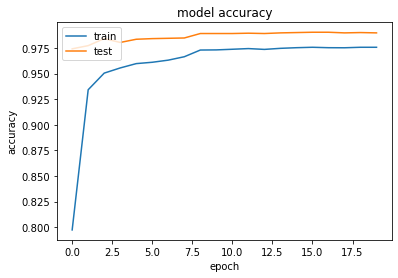

In [196]:
# summarize history for accuracy
plt.plot(bhistory.history['acc'])
plt.plot(bhistory.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

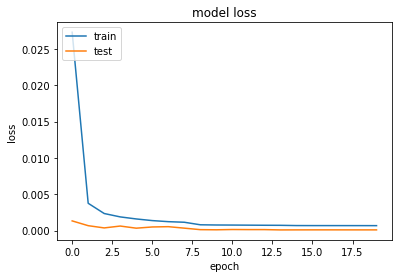

In [197]:
# summarize history for loss
plt.plot(bhistory.history['loss'])
plt.plot(bhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Multi Sensor input / autoencoder / single output model

In [159]:
# Config
encoder_dimension = 42
EPOCH = 20
BATCH_SIZE = 24

In [160]:
def build_multi_in_single_out_model(train_accel, train_gyro, train_quart):
    # Input dimension
    accel_dim = train_accel.shape[1]
    gyro_dim = train_gyro.shape[1]
    quart_dim = train_quart.shape[1]
    # All input
    input_accel = Input(shape=(accel_dim,), name='Input_Accel')
    input_gyro = Input(shape=(gyro_dim,), name='Input_Gyro')
    input_quart = Input(shape=(quart_dim,), name='Input_Quart')
    # Encoder branch for Accel
    accel_encoder = Dense(50, activation='relu', name='Encoder1_Accel')(input_accel)
    accel_encoder = Dense(25, activation='relu', name='Encoder2_Accel')(accel_encoder)
    # Encoder branch for Gyro
    gyro_encoder = Dense(50, activation='relu', name='Encoder1_Gyro')(input_gyro)
    gyro_encoder = Dense(25, activation='relu', name='Encoder2_Gyro')(gyro_encoder)
    # Encoder branch for Quart
    quart_encoder = Dense(50, activation='relu', name='Encoder1_Quart')(input_quart)
    quart_encoder = Dense(25, activation='relu', name='Encoder2_Quart')(quart_encoder)
    # Shared layer
    shared_input = Concatenate(name='Concatenate')([accel_encoder, gyro_encoder, quart_encoder])
    # Decoder
    decoder = Dense(5, activation='relu', name='Shared_Hidden_Layer')(shared_input)
    decoder = Dense(25, activation='relu', name='Decoder1')(decoder)
    decoder = Dense(50, activation='relu', name='Decoder2')(decoder)
    decoder = Dense(6, activation='relu', name='Output')(decoder)
    model = Model(inputs=([input_accel, input_gyro, input_quart]), outputs=decoder)
    return model

In [161]:
model = build_multi_in_single_out_model(train_accel, train_gyro, train_quart)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Accel (InputLayer)        (None, 6)            0                                            
__________________________________________________________________________________________________
Input_Gyro (InputLayer)         (None, 6)            0                                            
__________________________________________________________________________________________________
Input_Quart (InputLayer)        (None, 8)            0                                            
__________________________________________________________________________________________________
Encoder1_Accel (Dense)          (None, 50)           350         Input_Accel[0][0]                
__________________________________________________________________________________________________
Encoder1_G

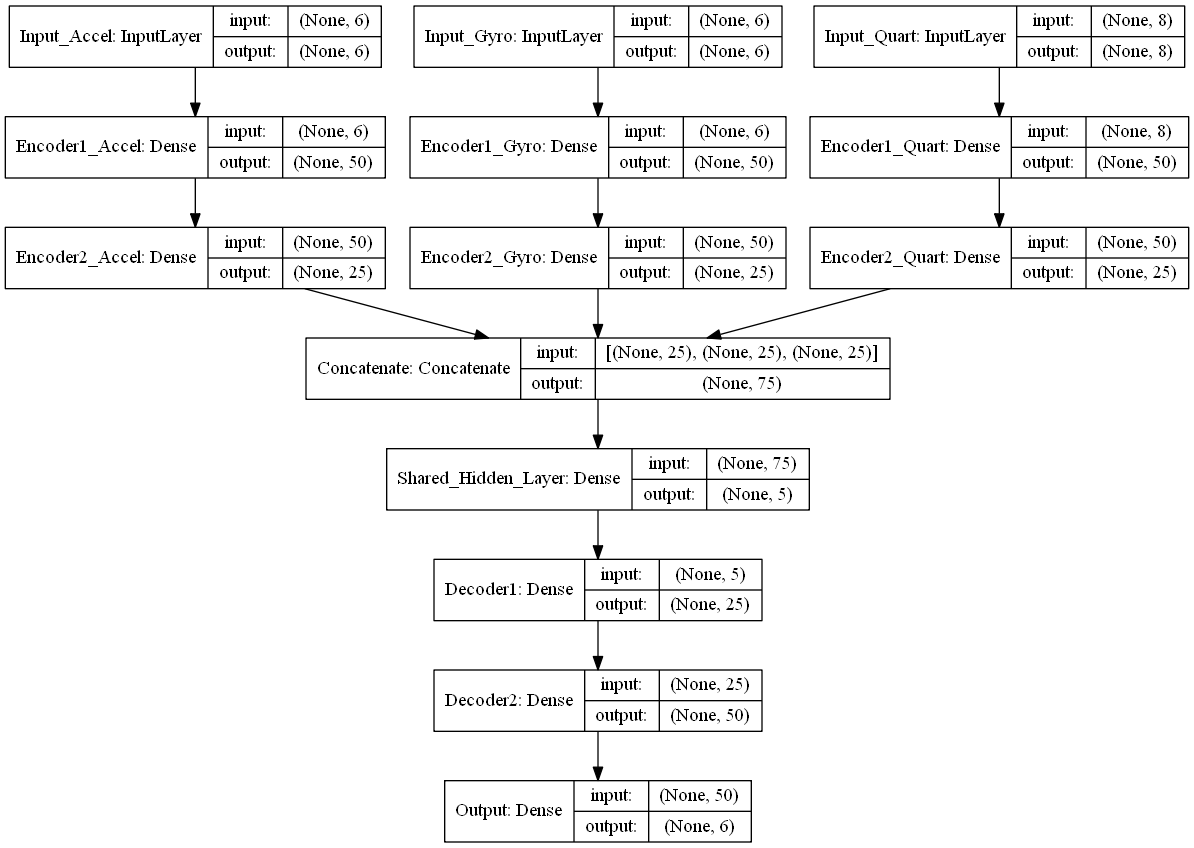

In [162]:
plot_model(model, 
           to_file='model.png', 
           show_shapes=True,
           show_layer_names=True)
IPython.display.Image('model.png')

In [163]:
model.compile(optimizer='adam', metrics=['accuracy'], loss=['mean_squared_logarithmic_error'])

In [165]:
%%time
history = model.fit([train_accel, train_gyro, train_quart], train_accel, 
                    validation_split=0.1, epochs=EPOCH, batch_size=BATCH_SIZE, shuffle=True, callbacks=callbacks)

Train on 28901 samples, validate on 3212 samples
Epoch 1/20
28901/28901 [==============================] - 19s 652us/step - loss: 0.0196 - acc: 0.8410 - val_loss: 0.0012 - val_acc: 0.9707
Epoch 2/20
28901/28901 [==============================] - 17s 580us/step - loss: 0.0025 - acc: 0.9460 - val_loss: 6.2269e-04 - val_acc: 0.9801
Epoch 3/20
28901/28901 [==============================] - 18s 638us/step - loss: 0.0018 - acc: 0.9548 - val_loss: 5.7816e-04 - val_acc: 0.9844
Epoch 4/20
28901/28901 [==============================] - 19s 673us/step - loss: 0.0015 - acc: 0.9593 - val_loss: 4.1497e-04 - val_acc: 0.9838
Epoch 5/20
28901/28901 [==============================] - 17s 585us/step - loss: 0.0014 - acc: 0.9621 - val_loss: 4.3824e-04 - val_acc: 0.9798
Epoch 6/20
28901/28901 [==============================] - 17s 574us/step - loss: 0.0013 - acc: 0.9637 - val_loss: 4.0179e-04 - val_acc: 0.9854
Epoch 7/20
28901/28901 [==============================] - 17s 591us/step - loss: 0.0012 - acc: 0.

In [166]:
test_predict = model.predict([test_accel, test_gyro, test_quart])
score, acc = model.evaluate([test_accel, test_gyro, test_quart], test_accel, batch_size=32)
print(f'Test Score: {score}')
print(f'Test Acc: {acc}')

8029/8029 [==============================] - 1s 124us/step
Test Score: 0.002306082573709347
Test Acc: 0.9687383235102203


In [167]:
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


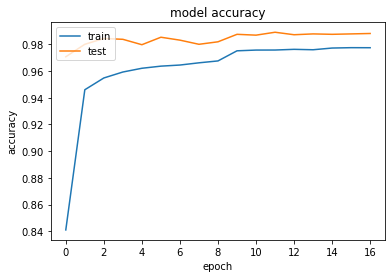

In [168]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

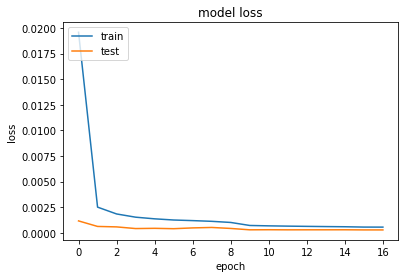

In [169]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [170]:
threshold = 6
dist = np.linalg.norm(test_accel - test_predict, axis=1)

In [171]:
for d in dist:
    if (d > threshold):
        print('Anomaly')

Anomaly
Anomaly
Anomaly


### Multi sensor input / autoencoder / multi output model

In [172]:
# Config
encoder_dimension = 42
EPOCH = 20
BATCH_SIZE = 24

In [173]:
def build_multi_in_multi_out_model(train_accel, train_gyro, train_quart):
    # Input dimension
    accel_dim = train_accel.shape[1]
    gyro_dim = train_gyro.shape[1]
    quart_dim = train_quart.shape[1]
    # All input
    input_accel = Input(shape=(accel_dim,), name='Input_Accel')
    input_gyro = Input(shape=(gyro_dim,), name='Input_Gyro')
    input_quart = Input(shape=(quart_dim,), name='Input_Quart')
    # Encoder branch for Accel
    accel_encoder = Dense(50, activation='relu', name='Encoder1_Accel')(input_accel)
    accel_encoder = Dense(25, activation='relu', name='Encoder2_Accel')(accel_encoder)
    # Encoder branch for Gyro
    gyro_encoder = Dense(50, activation='relu', name='Encoder1_Gyro')(input_gyro)
    gyro_encoder = Dense(25, activation='relu', name='Encoder2_Gyro')(gyro_encoder)
    # Encoder branch for Quart
    quart_encoder = Dense(50, activation='relu', name='Encoder1_Quart')(input_quart)
    quart_encoder = Dense(25, activation='relu', name='Encoder2_Quart')(quart_encoder)
    # Shared layer
    shared_input = Concatenate(name='Concatenate')([accel_encoder, gyro_encoder, quart_encoder])
    shared_hidden_layer = Dense(5, activation='relu', name='Shared_Hidden_Layer')(shared_input)
    # Decoder branch for Accel    
    accel_decoder = Dense(25, activation='relu', name='Decoder1_Accel')(shared_hidden_layer)
    accel_decoder = Dense(50, activation='relu', name='Decoder2_Accel')(accel_decoder)
    accel_decoder = Dense(6, activation='relu', name='Output_Accel')(accel_decoder)
    # Decoder branch for Gyro
    gyro_decoder = Dense(25, activation='relu', name='Decoder1_Gyro')(shared_hidden_layer)
    gyro_decoder = Dense(50, activation='relu', name='Decoder2_Gyro')(gyro_decoder)
    gyro_decoder = Dense(6, activation='relu', name='Output_Gyro')(gyro_decoder)
    # Decoder branch for Quart
    quart_decoder = Dense(25, activation='relu', name='Decoder1_Quart')(shared_hidden_layer)
    quart_decoder = Dense(50, activation='relu', name='Decoder2_Quart')(quart_decoder)
    quart_decoder = Dense(8, activation='relu', name='Output_Quart')(quart_decoder)
    
    
    model = Model(inputs=([input_accel, input_gyro, input_quart]), outputs=([accel_decoder, gyro_decoder, quart_decoder]))
    return model

In [174]:
model2 = build_multi_in_multi_out_model(train_accel, train_gyro, train_quart)
model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Accel (InputLayer)        (None, 6)            0                                            
__________________________________________________________________________________________________
Input_Gyro (InputLayer)         (None, 6)            0                                            
__________________________________________________________________________________________________
Input_Quart (InputLayer)        (None, 8)            0                                            
__________________________________________________________________________________________________
Encoder1_Accel (Dense)          (None, 50)           350         Input_Accel[0][0]                
__________________________________________________________________________________________________
Encoder1_G

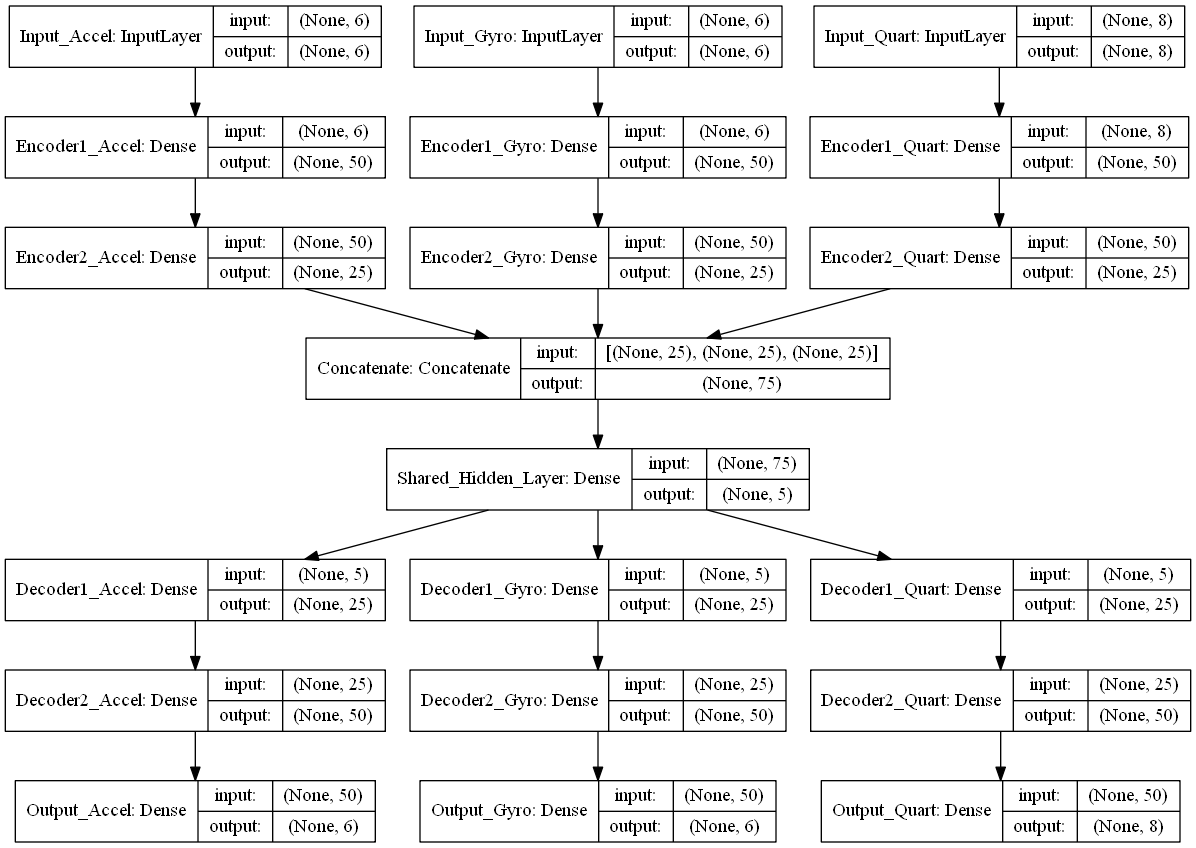

In [175]:
plot_model(model2, 
           to_file='model2.png', 
           show_shapes=True,
           show_layer_names=True)
IPython.display.Image('model2.png')

In [176]:
model2.compile(optimizer='adam', metrics=['accuracy'], 
               loss=['mean_squared_logarithmic_error', 'mean_squared_logarithmic_error', 'mean_squared_logarithmic_error'])

In [177]:
%%time
history2 = model2.fit([train_accel, train_gyro, train_quart], [train_accel, train_gyro, train_quart], 
                    validation_split=0.1, epochs=EPOCH, batch_size=BATCH_SIZE, shuffle=True, callbacks=callbacks)

Train on 28901 samples, validate on 3212 samples
Epoch 1/20
28901/28901 [==============================] - 41s 1ms/step - loss: 0.2185 - Output_Accel_loss: 0.0804 - Output_Gyro_loss: 0.0976 - Output_Quart_loss: 0.0405 - Output_Accel_acc: 0.5604 - Output_Gyro_acc: 0.4140 - Output_Quart_acc: 0.6532 - val_loss: 0.0911 - val_Output_Accel_loss: 0.0290 - val_Output_Gyro_loss: 0.0235 - val_Output_Quart_loss: 0.0387 - val_Output_Accel_acc: 0.7886 - val_Output_Gyro_acc: 0.2086 - val_Output_Quart_acc: 0.9754
Epoch 2/20
  120/28901 [..............................] - ETA: 37s - loss: 0.2151 - Output_Accel_loss: 0.0914 - Output_Gyro_loss: 0.0984 - Output_Quart_loss: 0.0253 - Output_Accel_acc: 0.5750 - Output_Gyro_acc: 0.3500 - Output_Quart_acc: 0.8000

D:\Anaconda3\envs\issmca3\lib\site-packages\keras\callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_Output_Accel_loss,val_Output_Gyro_loss,val_Output_Quart_loss,val_Output_Accel_acc,val_Output_Gyro_acc,val_Output_Quart_acc,loss,Output_Accel_loss,Output_Gyro_loss,Output_Quart_loss,Output_Accel_acc,Output_Gyro_acc,Output_Quart_acc,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


28901/28901 [==============================] - 38s 1ms/step - loss: 0.1757 - Output_Accel_loss: 0.0692 - Output_Gyro_loss: 0.0795 - Output_Quart_loss: 0.0270 - Output_Accel_acc: 0.6065 - Output_Gyro_acc: 0.4820 - Output_Quart_acc: 0.7799 - val_loss: 0.0869 - val_Output_Accel_loss: 0.0271 - val_Output_Gyro_loss: 0.0215 - val_Output_Quart_loss: 0.0383 - val_Output_Accel_acc: 0.7899 - val_Output_Gyro_acc: 0.2251 - val_Output_Quart_acc: 0.9829
Epoch 3/20
28901/28901 [==============================] - 38s 1ms/step - loss: 0.1649 - Output_Accel_loss: 0.0672 - Output_Gyro_loss: 0.0716 - Output_Quart_loss: 0.0261 - Output_Accel_acc: 0.6169 - Output_Gyro_acc: 0.4931 - Output_Quart_acc: 0.7905 - val_loss: 0.0875 - val_Output_Accel_loss: 0.0275 - val_Output_Gyro_loss: 0.0220 - val_Output_Quart_loss: 0.0380 - val_Output_Accel_acc: 0.7712 - val_Output_Gyro_acc: 0.2319 - val_Output_Quart_acc: 0.9857
Epoch 4/20
28901/28901 [==============================] - 38s 1ms/step - loss: 0.1463 - Output_Accel_

In [178]:
test_predict2 = model2.predict([test_accel, test_gyro, test_quart])
result = model2.evaluate([test_accel, test_gyro, test_quart], [test_accel, test_gyro, test_quart], batch_size=32)
for idx in range(len(model2.metrics_names)):
    print(f'{model2.metrics_names[idx]}: {result[idx]}')

8029/8029 [==============================] - 1s 95us/step
loss: 0.3486138212591176
Output_Accel_loss: 0.09413390164504236
Output_Gyro_loss: 0.11537634843916558
Output_Quart_loss: 0.13910356972680105
Output_Accel_acc: 0.41499564081415585
Output_Gyro_acc: 0.34823763860847307
Output_Quart_acc: 0.4364179848496236


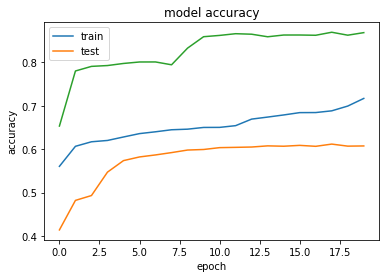

In [179]:
# summarize history for accuracy
plt.plot(history2.history['Output_Accel_acc'])
plt.plot(history2.history['Output_Gyro_acc'])
plt.plot(history2.history['Output_Quart_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

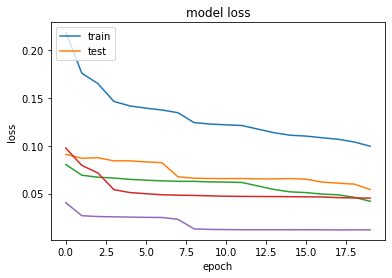

In [180]:
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.plot(history2.history['Output_Accel_loss'])
plt.plot(history2.history['Output_Gyro_loss'])
plt.plot(history2.history['Output_Quart_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()